**Update**

We've included `Bayesian Optimization` from [this notebook](https://www.kaggle.com/steubk/simple-oof-ensembling-methods-for-classification). Thanks to [steubk](https://www.kaggle.com/steubk). Aim was to compare with `scipy.optimize` function. 

---

In this notebook, we attempt to find the best weight vector for ensembling via trying to maximize **OOF CV** scores. The piece of code actually came from [this work](https://www.kaggle.com/tilii7/cross-validation-weighted-linear-blending-errors). 


**Disclaimer**

All the input scripts are designed for demonstratio purpose and also the procedure tha we've presented here. Please, use it to your own risk. Also note, in order to use it, you Have-To-Have **N** times `oof.csv` and `test.csv` that trained one the **same validation fold**. Thanks.

---

Set Up:

```
Model: E6
Seed : 42
Exp  : 5 Fold Training, Total 4 experiment [same fold trainig]
```

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score

dir = "../input/e6-oof-prediction//"
np.random.seed(42)

# exp 1 ___________
oof_one = pd.read_csv(dir + "oof_e6_exp1_seed_42.csv")
test_one = pd.read_csv(dir + "s_e6_exp1_seed_42.csv")
oof_one = oof_one.sort_values(by=["image_name"], ascending=True).reset_index(drop=True)
test_one = test_one.sort_values(by=["image_name"], ascending=True).reset_index(
    drop=True
)

# exp 2 ___________
oof_two = pd.read_csv(dir + "oof_e6_exp2_seed_42.csv")
test_two = pd.read_csv(dir + "s_e6_exp2_seed_42.csv")
oof_two = oof_two.sort_values(by=["image_name"], ascending=True).reset_index(drop=True)
test_two = test_two.sort_values(by=["image_name"], ascending=True).reset_index(
    drop=True
)

# exp 3 ___________
oof_three = pd.read_csv(dir + "oof_e6_exp3_seed_42.csv")
test_three = pd.read_csv(dir + "s_e6_exp3_seed_42.csv")
oof_three = oof_three.sort_values(by=["image_name"], ascending=True).reset_index(
    drop=True
)
test_three = test_three.sort_values(by=["image_name"], ascending=True).reset_index(
    drop=True
)

# exp 4 ___________
oof_four = pd.read_csv(dir + "oof_e6_exp4_seed_42.csv")
test_four = pd.read_csv(dir + "s_e6_exp4_seed_42.csv")
oof_four = oof_four.sort_values(by=["image_name"], ascending=True).reset_index(
    drop=True
)
test_four = test_four.sort_values(by=["image_name"], ascending=True).reset_index(
    drop=True
)


In [2]:
oof_one.fold.value_counts()

4    6555
2    6552
0    6536
1    6534
3    6515
Name: fold, dtype: int64

In [3]:
oof_one.head()

,image_name,target,pred,fold
0,ISIC_0015719,0,0.021981,0
1,ISIC_0052212,0,0.020979,4
2,ISIC_0068279,0,0.030942,0
3,ISIC_0074268,0,0.021772,0
4,ISIC_0074311,0,0.020974,2


In [4]:
test_one.head()

,image_name,target
0,ISIC_0052060,0.023545
1,ISIC_0052349,0.021493
2,ISIC_0058510,0.021546
3,ISIC_0073313,0.020786
4,ISIC_0073502,0.023138


# Scipy Optimizer

Let's try first optmization function from `Scipy`, usng `L-BFGS-B` method. We've tried other methods, but this one gave best.

In [5]:
blend_train = []
blend_test = []

# out of fold prediction
blend_train.append(oof_one.pred)
blend_train.append(oof_two.pred)
blend_train.append(oof_three.pred)
blend_train.append(oof_four.pred)
blend_train = np.array(blend_train)

# submission scores
blend_test.append(test_one.target)
blend_test.append(test_two.target)
blend_test.append(test_three.target)
blend_test.append(test_four.target)
blend_test = np.array(blend_test)

In [6]:
a = 0.12345
print("{0:.2f}".format(a))

0.12


In [7]:
def roc_min_func(weights):
    final_prediction = 0
    for weight, prediction in zip(weights, blend_train):
        final_prediction += weight * prediction
    return roc_auc_score(np.array(oof_one.target), final_prediction)


print("\n Finding Blending Weights ...")
res_list = []
weights_list = []

for k in range(100):
    starting_values = np.random.uniform(size=len(blend_train))
    bounds = [(0, 1)] * len(blend_train)

    res = minimize(
        roc_min_func,
        starting_values,
        method="L-BFGS-B",
        bounds=bounds,
        options={"disp": False, "maxiter": 100000},
    )

    res_list.append(res["fun"])
    weights_list.append(res["x"])

    
    res_fun = format(res["fun"], '.7f')
    items = [format(item, '.7f') for item in res["x"]]
    
    print(
        "{iter}\tScore: {score}\tWeights: {weights}".format(
            iter=(k + 1),
            score=res_fun,
            weights="\t".join([str(item) for item in items]),
        )
    )

bestSC = np.max(res_list)
bestWght = weights_list[np.argmax(res_list)]
weights = bestWght
blend_score = round(bestSC, 6)


 Finding Blending Weights ...
1	Score: 0.9316476	Weights: 0.3745401	0.9507143	0.7319939	0.5986585
2	Score: 0.9219291	Weights: 0.1560186	0.1559945	0.0580836	0.8661761
3	Score: 0.9279316	Weights: 0.6011150	0.7080726	0.0205845	0.9699099
4	Score: 0.9281132	Weights: 0.8324426	0.2123391	0.1818250	0.1834045
5	Score: 0.9316281	Weights: 0.3042422	0.5247564	0.4319450	0.2912291
6	Score: 0.9295422	Weights: 0.6118529	0.1394939	0.2921446	0.3663618
7	Score: 0.9307547	Weights: 0.4560700	0.7851760	0.1996738	0.5142344
8	Score: 0.9274283	Weights: 0.5924146	0.0464504	0.6075449	0.1705241
9	Score: 0.9310607	Weights: 0.0650516	0.9488855	0.9656320	0.8083973
10	Score: 0.9293355	Weights: 0.3046138	0.0976721	0.6842330	0.4401525
11	Score: 0.9256867	Weights: 0.1220382	0.4951769	0.0343885	0.9093204
12	Score: 0.9312611	Weights: 0.2587800	0.6625223	0.3117111	0.5200680
13	Score: 0.9297988	Weights: 0.5467103	0.1848545	0.9695846	0.7751328
14	Score: 0.9312204	Weights: 0.9394989	0.8948274	0.5979000	0.9218742
15	Score: 0.

In [8]:
print('\n Ensemble Score: {best_score}'.format(best_score=bestSC))
print('\n Best Weights: {weights}'.format(weights=bestWght))

train_prices = np.zeros(len(blend_train[0]))
test_prices  = np.zeros(len(blend_test[0]))

print('\n Your final model:')
for k in range(len(blend_test)):
    print(' %.6f * model-%d' % (weights[k], (k + 1)))
    test_prices += blend_test[k] * weights[k]

for k in range(len(blend_train)):
    train_prices += blend_train[k] * weights[k]


 Ensemble Score: 0.9316942291023538

 Best Weights: [0.36778313 0.63230583 0.63352971 0.53577468]

 Your final model:
 0.367783 * model-1
 0.632306 * model-2
 0.633530 * model-3
 0.535775 * model-4


In [9]:
test_one.target = (
    test_one.target.values * bestWght[0]
    + test_two.target.values * bestWght[1]
    + test_three.target.values * bestWght[2]
    + test_four.target.values * bestWght[3]
) / max(bestWght)


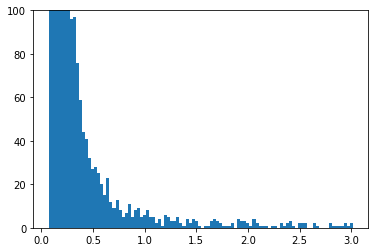

In [10]:
plt.hist(test_one.target,bins=100)
plt.ylim((0,100))
plt.show()

# Bayesian Optimization

Next, Bayesian. 

In [11]:
train = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

In [12]:
dirname = '/kaggle/input/e6-oof-prediction'
prefix = ['exp1', 'exp2', 'exp3', 'exp4', ]

for model in range(4):
    _oof = pd.read_csv(os.path.join(dirname, f"oof_e6_{prefix[model]}_seed_42.csv"))
    score = roc_auc_score(_oof['target'], _oof['pred'])
    print(f"{prefix[model]}: OOF auc:{score:.4}")

    _oof = _oof.rename(columns={"pred":prefix[model]}).drop(["target"],axis=1)
    
    if "fold" in _oof.columns:
        _oof = _oof.drop(["fold"],axis=1)

    train = train.merge(_oof, on="image_name")   

    _sub = pd.read_csv(os.path.join(dirname, f"s_e6_{prefix[model]}_seed_42.csv"))
    _sub.columns = ["image_name", prefix[model]]    
    test = test.merge(_sub, on="image_name")  

exp1: OOF auc:0.9117
exp2: OOF auc:0.9178
exp3: OOF auc:0.9038
exp4: OOF auc:0.9053


In [13]:
def dim_optimizer (df_oof, features, init_points = 20, n_iter = 100 ):
    pbounds = {'c0': (0.0, 1.0), 
               'c1': (0.0, 1.0), 
               'c2': (0.0, 1.0), 
               'c3': (0.0, 1.0)}
    
    features = features

    def dim_opt (df_oof, c0,c1,c2,c3):

        x = (c0*df_oof[features[0]] + 
             c1*df_oof[features[1]] + 
             c2*df_oof[features[2]] + 
             c3*df_oof[features[3]])
        
        return roc_auc_score(df_oof['target'], x)



    def q (c0,c1,c2,c3):
        return dim_opt  ( df_oof, c0,c1,c2,c3)

    optimizer = BayesianOptimization(
        f=q,
        pbounds=pbounds,
        random_state=42,
    )


    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter,
    )

    c0 = optimizer.max["params"]["c0"]
    c1 = optimizer.max["params"]["c1"]
    c2 = optimizer.max["params"]["c2"]
    c3 = optimizer.max["params"]["c3"]
    t  = optimizer.max["target"]
    
    print ( f'bo auc:{t}, c0:{c0}, c1:{c1}, c2:{c2}, c3:{c3}' )
    
    return c0, c1, c2, c3


c0, c1, c2, c3 = dim_optimizer (train, prefix, 
                                init_points = 40, 
                                n_iter = 40  )

print(' ')
print (prefix[0],c0)
print (prefix[1],c1)
print (prefix[2],c2)
print (prefix[3],c3)

|   iter    |  target   |    c0     |    c1     |    c2     |    c3     |
-------------------------------------------------------------------------
|  1        |  0.9316   |  0.3745   |  0.9507   |  0.732    |  0.5987   |
|  2        |  0.9219   |  0.156    |  0.156    |  0.05808  |  0.8662   |
|  3        |  0.9279   |  0.6011   |  0.7081   |  0.02058  |  0.9699   |
|  4        |  0.9281   |  0.8324   |  0.2123   |  0.1818   |  0.1834   |
|  5        |  0.9316   |  0.3042   |  0.5248   |  0.4319   |  0.2912   |
|  6        |  0.9295   |  0.6119   |  0.1395   |  0.2921   |  0.3664   |
|  7        |  0.9308   |  0.4561   |  0.7852   |  0.1997   |  0.5142   |
|  8        |  0.9274   |  0.5924   |  0.04645  |  0.6075   |  0.1705   |
|  9        |  0.9311   |  0.06505  |  0.9489   |  0.9656   |  0.8084   |
|  10       |  0.9293   |  0.3046   |  0.09767  |  0.6842   |  0.4402   |
|  11       |  0.9257   |  0.122    |  0.4952   |  0.03439  |  0.9093   |
|  12       |  0.9313   |  0.2588   | 

In [14]:
def bo_pred(df):
    x = (
        c0 * df[prefix[0]]
        + c1 * df[prefix[1]]
        + c2 * df[prefix[2]]
        + c3 * df[prefix[3]]
    )

    return x


train["pred"] = bo_pred(train)
score = roc_auc_score(train["target"], train["pred"])
print(f"auc bo:{score}")


auc bo:0.9316718240316467


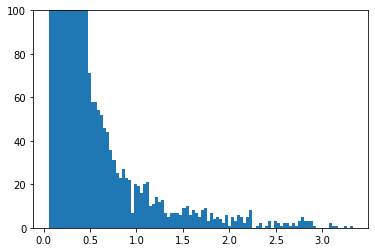

In [15]:
plt.hist(train.pred,bins=100)
plt.ylim((0,100))
plt.show()

## Compare L-BFGS-B vs Bayesian Operations


|  Method | CV  |  
|---|---|
| L-BFGS-B  | 0.9316942291023538  |   
| Bayesian-Op  | 0.9316718240316467  |